In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma

### 1. Entanglement entropy

One approach to studying quantum correlations in spin chains is calculating the bipartite entropy of entanglement between a subsystem $A$ of $L$ contiguous particles and the rest of the system, when it is in a pure state $\rho$:

$$
S = s[\rho_A]
$$

$$
\begin{aligned}
\rho_A &= \mathrm{tr}_{\bar A} \rho, & \bar{A} &= \{0, ..., N-1\}\backslash A
\end{aligned}
$$

for an appropriate entropy functional $s$. Since the state is pure we may take it to be $|M\rangle=\prod\limits_{n=0}^{M-1}\tilde{a}^\dagger_n|0\rangle$. We can then calculate the $L\times L$ correlation matrix [2], $C(L, M)\equiv C$ 

$$
\begin{aligned}
C_{nm} &= \langle M|a^\dagger_n a_m|M\rangle, & n,m = 0, ..., L-1
\end{aligned}
$$

It is easy to check that

$$
\begin{aligned}
\langle M|\tilde{a}^\dagger_n\tilde{a}_m|M\rangle &= \delta_{nm}\chi_M, & \chi_M &=
    \begin{cases}
    1, \quad n\in\{0, ..., M-1\} \\
    0, \quad n\not\in\{0, ..., M-1\}
    \end{cases}
\end{aligned}
$$

And then since $a_n = \sum\limits_{k=0}^{N-1} \Phi_{nk}\tilde{a}_k$

$$
C_{nm} = \sum\limits_{j=0}^{N-1}\sum\limits_{k=0}^{N-1}\Phi_{nj}\Phi_{mk}\delta_{jk}\chi_M=
\sum\limits_{k=0}^{M-1}\Phi_{nk}\Phi_{mk}=
\boxed{
\sum\limits_{k=0}^{M-1}\frac{w_k}{\sqrt{\gamma_n \gamma_m}} P_n(\varepsilon_k)P_m(\varepsilon_k)
}
$$

In [10]:
# Calculating correlation matrix
def OPS(N, a, b):
    P = np.zeros((N+1, N+1))
    P[0, N] = 1
    P[1, -2:] = [1, - b[0]]
    for n in range(1, N):
        P[n+1] = np.roll(P[n], -1) - b[n] * P[n] - a[n-1] * P[n-1]
    return P

def corr(N, J, h, L, M):
    P = OPS(N, J**2, h)
    E = np.sort(np.roots(P[N]))[:M]
    gamma = np.cumprod(J)**2
    gamma = np.append(1, gamma)
    denominator = np.polyval(P[N-1], E) * np.polyval(np.polyder(P[N]), E)
    w = np.prod(J)**2 / denominator
    C = np.empty((L, L))
    for n in range(L):
        C[n] = [np.sum(w*np.polyval(P[n], E)*np.polyval(P[m], E))/np.sqrt(gamma[n]*gamma[m]) for m in range(L)]
    return C

# Example / test
N = 5
J = np.linspace(1, N-1, N-1)
h = np.ones(N)
L, M = 3, 3
C = corr(N, J, h, L, M)
print('Correlation matrix from orthogonal polynomial system: ')
print(np.around(C, 3))

H1 = np.diag(h) + np.diag(J, 1) + np.diag(J, -1)
Phi = np.linalg.eigh(H1)[1][:L, :M]
print('Correlation matrix from diagonalisation: ')
print(np.around(Phi @ Phi.T, 3))

Correlation matrix from orthogonal polynomial system: 
[[ 0.86  -0.261 -0.18 ]
 [-0.261  0.5   -0.386]
 [-0.18  -0.386  0.59 ]]
Correlation matrix from diagonalisation: 
[[ 0.86  -0.261 -0.18 ]
 [-0.261  0.5   -0.386]
 [-0.18  -0.386  0.59 ]]


Refs. [2], [3] study Rényi entropy $s_\alpha$:

$$
\begin{aligned}
s_\alpha[\rho_A] &= \frac{1}{1-\alpha}\log\mathrm{tr}(\rho^\alpha_A), & \alpha>0
\end{aligned}
$$

$$
s[\rho_A]\equiv\lim\limits_{\alpha\rightarrow1}s_\alpha[\rho_A]=-\mathrm{tr}(\rho_A\log\rho_A)
$$

Let's briefly outline the algorithm explained in ref. [1] for calculating $s[\rho_A]$ from the correlation matrix. Starting with

$$
C_{nm} = \langle M|a^\dagger_n a_m|M\rangle = \mathrm{tr}(a^\dagger_n a_m \rho_A)
$$

since $C$ is real symmetric, it is orthogonally diagonalisable

$$
\begin{aligned}
G_{nm} = (RCR^\mathrm{T})_{nm} &= \mathrm{tr}(g^\dagger_n g_m \rho_A) = \nu_n \delta_{nm}, &
g_n = \sum\limits_{k=0}^{L-1} R_{nk} a_k
\end{aligned}
$$

which implies $\rho_A$ is uncorrelated and can be written as

$$
\rho_A = \rho_0 \otimes ... \otimes \rho_{L-1}
$$

In the $\{|0\rangle, |1\rangle\}\equiv\{\mathrm{vacuum}, \mathrm{fermion}\}$ single particle (rotated) basis, the matrices of our operators are 

$$
\begin{aligned}
g_i &= \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}, &
g^\dagger_i &= \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}, &
\rho_i &= \begin{pmatrix} 1-\alpha_i & \beta^*_i \\ \beta_i & \alpha_i \end{pmatrix}
\end{aligned}
$$

We can now calculate the elements of the $\rho_i$ matrices:

$$
\begin{aligned}
\langle M|g_i |M\rangle &= 0, &
\langle M|g_i |M\rangle &= \mathrm{tr}(g_i\rho_i) = \beta_i & \Rightarrow &&
\beta_i &= 0
\end{aligned}
$$

$$
\begin{aligned}
\mathrm{tr}(g^\dagger_i g_i\rho_i) &= \nu_i, &
\mathrm{tr}(g^\dagger_i g_i\rho_i) &= \alpha_i & \Rightarrow &&
\alpha_i = \nu_i
\end{aligned}
$$

And finally

$$
\boxed{
\rho_A = \bigotimes\limits_{i=0}^{L-1} \mathrm{diag}(1-\nu_i, \nu_i)
}
$$

So once we have computed the correlation matrix, we can use it's eigenvalues $\nu_i$ to compute entropy via the formula

$$
\boxed{
S = \sum\limits_{i=0}^{L-1}s^{(2)}(\nu_i)
}
$$

where $s^{(2)}$ is the binary entropy

$$
s_\alpha^{(2)}(x) = \frac{1}{1-\alpha}\log(x^\alpha+(1-x)^\alpha)
$$

$$
s^{(2)}(x) = -x\log x-(1-x)\log(1-x)
$$

Since $C = \Phi_{LM}\Phi_{LM}^\mathrm{T}$ is real, symmetric, positive definite, and so is $I-C$, then $0\leq\nu_i\leq1$, as expected for probabilities.

In [11]:
def bin_entropy(alpha, nu):
    if alpha == 1:
        return - nu * np.log(nu) - (1 - nu) * np.log(1 - nu)
    return np.log(nu ** alpha + (1 - nu) ** alpha) / (1 - alpha)

# Example / test
N = 5
J = np.linspace(1, N-1, N-1)
h = np.ones(N)
L, M = 3, 3
a = 1

C = corr(N, J, h, L, M)
nu = np.linalg.eigvalsh(C)
S = np.sum(bin_entropy(a, nu))
print(f'Entanglement entropy: {S}')

Entanglement entropy: 0.4509754963522565


### 2. Homogeneous XX chain

#### 2.1 Diagonalisation

The homogeneous chain studied in [1] has $J_n=J\in\mathbb{R}$, $h_n=h\in\mathbb{R}$. If we considered periodic boundary conditions, the system would be invariant under translations (all sites on the chain look the same). Translational invariance would imply momentum conservation, therefore we should work in the momentum (Fourier) basis.

$$
\tilde{a}_k = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} a_n e^{-i\frac{2\pi}{N}nk}
$$

So $E=\Phi^\dagger H^1\Phi$, with the diagonalisation being $\Phi_{nk}=\frac{1}{\sqrt{N}}e^{-i\frac{2\pi}{N}nk}$. Let's naively apply this diagonalisation to the $H^1$ matrix with free boundary conditions:

$$
\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}\Phi^\dagger_{jn} H^1_{nm} \Phi_{mk} = 
\frac{1}{N}\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}e^{i\frac{2\pi}{N}jn}e^{-i\frac{2\pi}{N}mk}(J\delta_{n+1,m}+J\delta_{n-1,m}+h\delta_{nm}) =
$$

$$
= \frac{1}{N}\left(
(e^{i\frac{2\pi}{N}k}+e^{-i\frac{2\pi}{N}k})J\sum\limits_{n=0}^{N-2}e^{i\frac{2\pi}{N}n(j-k)}+
h\sum\limits_{n=0}^{N-1}e^{i\frac{2\pi}{N}n(j-k)}
\right) =
$$

$$
= \left(2\cos\left(\frac{2\pi k}{N}\right)J+h\right)\delta_{jk}+ o\left(\frac{1}{N}\right)
$$

$$
\boxed{
\begin{aligned}
    H&\approx\sum\limits_{k=0}^{N-1}\varepsilon_k\tilde{a}^\dagger_k\tilde{a}_k, &
    \varepsilon_k&\approx2\cos\left(\frac{2\pi k}{N}\right)J+h
\end{aligned}
}
$$

The diagonalisation still works in the thermodynamic limit, when $N\rightarrow\infty$.

Text(0, 0.5, 'max |off diagonal|')

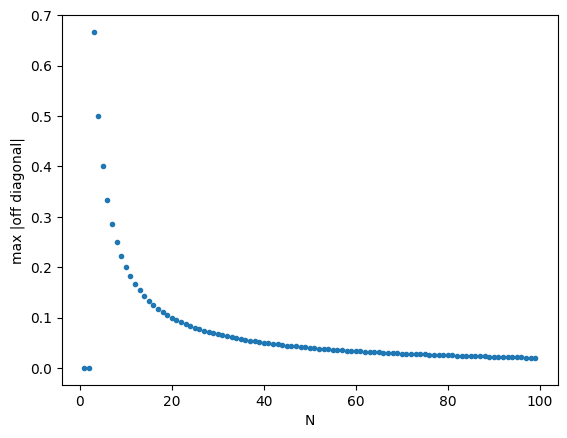

In [12]:
# Numerical test
@np.vectorize()
def offdiag_max(N, J, h):
    H1 = h * np.diag(np.ones(N)) + J * (np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1))
    FT = np.fft.fft(np.eye(N), norm='ortho') # Fourier transform matrix
    E = np.conj(FT) @ H1 @ FT 
    return np.max(np.abs(E-np.diag(np.diag(E))))

Nmax = 100
J = 1
h = 2

N = np.arange(1, Nmax)
o = offdiag_max(N, J, h)
plt.plot(N, o, '.')
plt.xlabel('N')
plt.ylabel(r'max |off diagonal|')

We can now easily find the ground state. It will have one particle at each site that $\varepsilon_n$ is negative, therefore there are only particles where

$$
- \left(\frac{h}{J}\right) > 2\cos\left(\frac{2\pi k}{N}\right)
$$

Or, in other words

$$
\begin{aligned}
k_c \leq k \leq N - k_c, & & k_c &= \left\lceil\frac{N}{2\pi}\arccos\left(\frac{-h}{2J} \right)\right\rceil
\end{aligned}
$$

We then realise that if $h/J>2$ (the magnetic field is strong), the ground state is the vacuum $|0\rangle$ (all spins up).

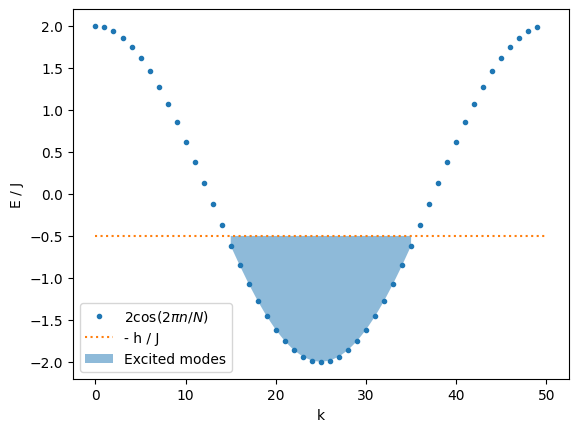

In [13]:
# Let's visualise this
N = 50
J = 2
h = 1

kc = int(np.ceil(N * np.arccos(- h / (2*J)) / (2 * np.pi)))
k = np.linspace(0, N-1, N)
osc = 2 * np.cos(2 * np.pi * k / N)
plt.plot(k, osc, '.')
plt.plot([0, N], [-h/J, -h/J], ':')
plt.fill_between(k[kc:N-kc+1], osc[kc:N-kc+1], - h / J, alpha=.5)
plt.xlabel('k')
plt.ylabel('E / J')
plt.legend(['$2\cos(2\pi n/N)$', '- h / J', 'Excited modes'])

#### 2.2 Correlation Matrix

Now the system has been diagonalised, we can calculate its correlation matrix:

$$
C_{nm} = \sum_{k=N/2-M/2}^{N/2+M/2} \Phi_{nk} \Phi^*_{mk}
 = \frac{1}{N} \sum_{k=-M/2}^{M/2} e^{-i\frac{2\pi}{N}(k+N/2)(n-m)} =
$$

$$
=  \frac{1}{N} \sum_{k=-M/2}^{M/2} \cos\left(\pi\left(\frac{2k}{N}+1\right)(n-m)\right) = 
(-1)^{n-m} \frac{2}{N} \sum_{k=0}^{M/2} \cos\left(\frac{2\pi k}{N}(n-m)\right)
$$

And in the thermodynamic limit

$$
C_{nm} \approx 2(-1)^{n-m} \int_0^{M/2N} \mathrm{d}x \cos(2\pi x(n-m)) = 
\boxed{(-1)^{n-m}\frac{M}{N}\mathrm{sinc}\left(\frac{\pi M}{N}(n-m)\right)}
$$

Let's verify this.

C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\125348673.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  C[n] = [np.sum(w*np.polyval(P[n], E)*np.polyval(P[m], E))/np.sqrt(gamma[n]*gamma[m]) for m in range(L)]
C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\125348673.py:15: RuntimeWarning: overflow encountered in multiply
  denominator = np.polyval(P[N-1], E) * np.polyval(np.polyder(P[N]), E)
C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\125348673.py:16: RuntimeWarning: invalid value encountered in divide
  w = np.prod(J)**2 / denominator


Text(0, 0.5, 'max |C$_{the}$ - C$_{num}$|')

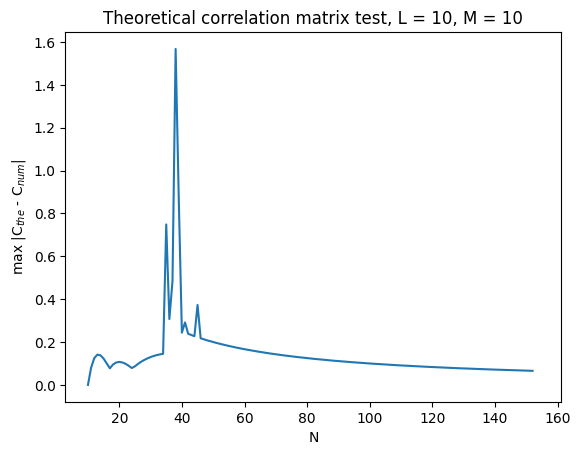

In [14]:
# Homogeneous chain correlation matrix
def corr_homogeneous(N, L, M):
    C = np.empty((L, L))
    for n in range(L):
        for m in range(L):
            C[n, m] = (-1)**(n-m) * M/N * np.sinc(M/N*(n-m))
    return C

# Test
N = np.arange(10, 160)
J = 2
h = -1
L, M = 10, 10

@np.vectorize
def error(N, J, h, L, M):
    C_the = corr_homogeneous(N, L, M)
    C_num = corr(N, J * np.ones(N-1), h * np.ones(N), L, M)
    return np.max(np.abs(C_the - C_num))

err = error(N, J, h, L, M)
plt.plot(N, err)
plt.title(f'Theoretical correlation matrix test, L = {L}, M = {M}')
plt.xlabel('N')
plt.ylabel('max |C$_{the}$ - C$_{num}$|')
# Here we run into some tolerance issues which could be resolved with more careful code and precision 
# management. We can still see the error decreasing.

#### 2.3 Entanglement Entropy

So now all that remains is calculating the entanglement entropy. The procedure described in Refs. [1], [4] is rather involved. One starts by defining

$$
D(\mu) = \mathrm{det}(\mu I - C) = \prod_{i=0}^{L-1} (\mu - \nu_i)
$$

The Fisher-Hartwig conjecture provides an asymptotic expression for $D(\mu)$, which can be plugged into Cauchy's integral formula:

$$
S = \sum\limits_{i=0}^{L-1}e(1+\epsilon, \nu_i) = 
\sum\limits_{i=0}^{L-1}\frac{1}{2\pi i}\oint_{c(\epsilon,\delta)} \frac{e(1+\epsilon,\mu)}{\mu-\nu_i}\mathrm{d}\mu =
\frac{1}{2\pi i}\oint_{c(\epsilon,\delta)} e(1+\epsilon,\mu)\ \mathrm{d}(\log D(\mu))
$$

Here $e(1+\epsilon,\mu)$ is an analytic function such that $e(1, \nu_i)=s^{(2)}(\nu_i)$, and $c(\epsilon, \delta)$ is a dumbbell-shaped contour enclosing all eigenvalues $\nu_i$ on the real line [4]. We then take $\epsilon,\delta\rightarrow0^+$.

Finally, for a system filled up to $M=k_c$, Ref. [1] presents the analytical result for Shannon entropy. Ref. [3] however presents a more complete result. If we define $\lambda=\lim\limits_{N\rightarrow\infty} L/N$, the size of the studied block of particles relative to the entire system, the Rényi entropy at arbitrary filling for open boundary conditions is given by

$$
S_\alpha(N,\lambda) = \frac{c}{12}(1+\alpha^{-1})\log f(N,\lambda) + c'_\alpha +
\begin{cases}
O(N^{-1}), 
\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \alpha<1 \\
\mu_\alpha\sin(\pi(2L+1)k_F) f(N, \lambda)^{-1/\alpha} + o(N^{-1/\alpha}),
\quad \alpha\geq1
\end{cases}
$$

There are many important points to discuss:

- $c$ is the central charge of a CFT related to the spin chain, at half filling $c=1$. It determines the model's universality class.

- $c'_\alpha = \frac{1}{2}(1+\alpha^{-1})\left\{\frac{\log2}{3} + \int_0^\infty\left[\frac{\mathrm{csch}\ t}{1-\alpha^{-2}}(\alpha^{-1}\mathrm{csch}(t/\alpha)-\mathrm{csch}\ t)-\frac{e^{-2t}}{6} \right]\frac{\mathrm{d}t}{t} \right\} $, noting that $\lim\limits_{\alpha\rightarrow1}\frac{\mathrm{csch}\ t}{1-\alpha^{-2}}(\alpha^{-1}\mathrm{csch}(t/\alpha)-\mathrm{csch}\ t) = \frac{1}{2}(t\ \mathrm{coth}\ t-1)\mathrm{csch}^2 t $, an ugly formula but nothing special. It is a non-universal constant [3].

- $f(N, \lambda)=\frac{N}{\pi}\sin(\pi\lambda)\sin(\pi k_F)$

- $k_F = M/N$ is the Fermi momentum, given by the last filled level.

- $\mu_\alpha = \frac{2^{1-\frac{2}{\alpha}}}{1-\alpha}\frac{\Gamma(\frac{1}{2}+\frac{1}{2\alpha})}{\Gamma(\frac{1}{2}-\frac{1}{2\alpha})},\quad\lim\limits_{\alpha\rightarrow1}\mu_\alpha=-\frac{1}{4}$

- $\sin(\pi(2L+1)k_F)$ produces parity oscillations, which for large $\alpha$ can obscure the leading asymptotic terms [3].

This complicated result is important because it allows us to guess the shape of $S_\alpha$ for inhomogeneous chains under certain conditions.

C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\590573918.py:9: RuntimeWarning: overflow encountered in sinh
  fa = lambda t: ((1 / (a*np.sinh(t/a)) - 1 / np.sinh(t)) / ((1-a**-2)*np.sinh(t)) - np.exp(-2*t)/6) / t


Text(0, 0.5, '$S_\\alpha$')

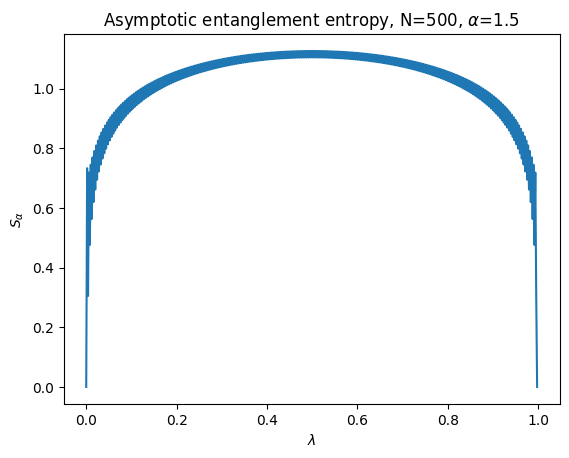

In [15]:
# Non-universal constant
def cp(a):
    # Integral for a = 1
    if a == 1:
        f1 = lambda t: .5 * (t / np.tanh(t) - 1) / np.sinh(t) ** 2
        integral = quad(f1, 0, np.inf)[0]
    # Integral for a =/= 1
    else:
        fa = lambda t: ((1 / (a*np.sinh(t/a)) - 1 / np.sinh(t)) / ((1-a**-2)*np.sinh(t)) - np.exp(-2*t)/6) / t
        integral = quad(fa, 0, np.inf)[0]
    # Constant
    cp = .5 * (1 + 1/a) * (np.log(2)/3 + integral)
    return cp

# f function
def f(N, lamb, kF):
    return N / np.pi * np.sin(np.pi*lamb) * np.sin(np.pi*kF)

# mu function
def mu(a):
    if a == 1:
        return - .25
    return 2**(1 - 2/a) / (1 - a) * gamma(1/2 + 1/(2*a)) / gamma(1/2 - 1/(2*a))

# Asymptotic Rényi entropy
def S_asymptotic(c, a, N, L, M):
    S = np.zeros_like(L, dtype=np.float64)
    nonzero = np.where((L != 0) * (L != N-1))
    lamb = L[nonzero] / N
    kF = M / N
    S[nonzero] = c/12 * (1 + a**-1) * np.log(f(N, lamb, kF)) + cp(a)
    if a < 1:
        return S
    S[nonzero] += mu(a) * np.sin(np.pi * (2*L[nonzero] + 1) * kF) * f(N, lamb, kF) ** (-1/a)
    return S

# Example/test
c = 1
a = 1.5
N = 500
L = np.arange(N)
M = N / 2

plt.plot(L / N, S_asymptotic(c, a, N, L, M))
plt.title(rf'Asymptotic entanglement entropy, N={N}, $\alpha$={a:.2e}'.rstrip('e+00'))
plt.xlabel('$\lambda$')
plt.ylabel(r'$S_\alpha$')
# More tolerance issues, should be fixable with careful coding

C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\590573918.py:9: RuntimeWarning: overflow encountered in sinh
  fa = lambda t: ((1 / (a*np.sinh(t/a)) - 1 / np.sinh(t)) / ((1-a**-2)*np.sinh(t)) - np.exp(-2*t)/6) / t


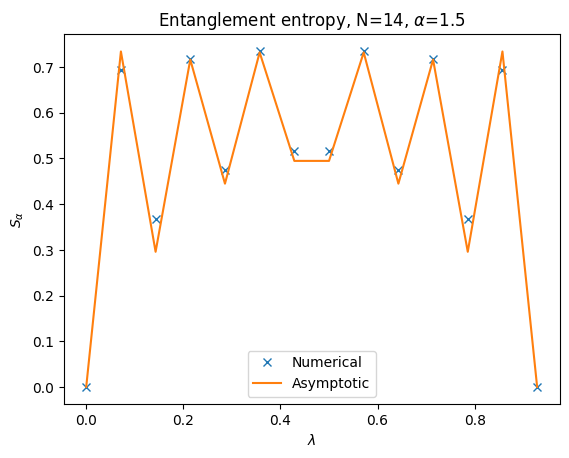

In [16]:
# Comparison of numerical solution against asymptotic solution 
# Requires sampling much fewer points
c = 1
a = 1.5
N = 14
J = 2 * np.ones(N-1)
h = - np.ones(N)
L = np.arange(int(N/2))
M = int(N/2)

C = [corr(N, J, h, Li, M) for Li in L]
nu = [np.linalg.eigvalsh(Ci) for Ci in C]
S_num = [np.sum(bin_entropy(a, nui)) for nui in nu]
S_asm = S_asymptotic(c, a, N, L, M)

L = np.arange(N)
plt.plot(L / N, [*S_num, *S_num[::-1]], 'x', label='Numerical')
plt.plot(L / N, [*S_asm, *S_asm[::-1]], label='Asymptotic')
plt.title(rf'Entanglement entropy, N={N}, $\alpha$={a:.2e}'.rstrip('e+00'))
plt.xlabel('$\lambda$')
plt.ylabel(r'$S_\alpha$')
plt.legend()
# More numerical issues, even with few particles

### 3. General case

Inhomogeneous spin chains hold no relation to CFTs, except at half filling, when according to [3], in the continuous limit, the Hamiltonian coincides with that of a free massless Dirac (regular) fermion in spacetime with static metric

$$
\mathrm{d}s^2 = J(x)^2 \mathrm{d}t^2 - \mathrm{d}x^2
$$

where $J(x)$ is the continuum limit of $J_n$ and $x=n\Delta x,\ \mathcal{L}=(N-1)\Delta x \Rightarrow\ x\in[0, \mathcal{L}]$, for some length $\mathcal{L}$. In isothermal coordinates:

$$
\mathrm{d}s^2 = J(x)^2 (\mathrm{d}t^2 - \mathrm{d}\tilde{x}^2)
$$

We can therefore define the conformal lengths

$$
\begin{aligned}
\Delta\tilde{x} &= \frac{\Delta x}{J(\ell)}, &
\tilde{\ell} &= \tilde{x}(\ell), &
\tilde{\mathcal{L}} &= \tilde{x}(\mathcal{L}) 
\end{aligned}
$$

given by

$$
\tilde{x}(x) = \int_0^x \frac{\mathrm{d}s}{J(s)}
$$

So the following holds:

$$
\boxed{
S_\alpha = \frac{1}{12}(1+\alpha^{-1})\log f(N, \lambda) + c'_\alpha + o(1)
}
$$

$$
f(N, \lambda) = \frac{\tilde{\mathcal{L}}}{\pi\Delta\tilde{x}}\sin\left(\frac{\pi\tilde{\ell}}{\tilde{\mathcal{L}}}\right)\approx
\frac{N\tilde{\mathcal{L}}/\mathcal{L}}{\pi}J(\ell)\sin\left(\frac{\pi\tilde{\ell}}{\tilde{\mathcal{L}}}\right)
$$

where $c'_\alpha$ is not necessarily given by the previous formula. Ref. [3] conjectures an extension to the formula for $k_F=1/2$ and $h_n=const.$, however for many models it does not hold:

$$
S_\alpha(N,\lambda) = \frac{1}{12}(1+\alpha^{-1})\log f(N,\lambda) + c'_\alpha +
\begin{cases}
O(N^{-1}), 
\qquad\qquad\qquad\qquad\qquad\quad \alpha<1 \\
\mu_\alpha(-1)^L f(N, \lambda)^{-1/\alpha} + o(N^{-1/\alpha}),
\quad \alpha\geq1
\end{cases}
$$

C:\Users\zapat\AppData\Local\Temp\ipykernel_1544\590573918.py:9: RuntimeWarning: overflow encountered in sinh
  fa = lambda t: ((1 / (a*np.sinh(t/a)) - 1 / np.sinh(t)) / ((1-a**-2)*np.sinh(t)) - np.exp(-2*t)/6) / t


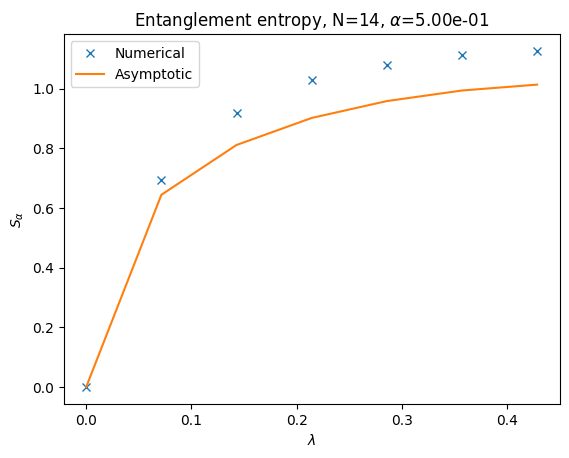

In [23]:
# Brief test of XX chain model classes
import models

N = 14
q = .5
K = models.Krawtchouk(N, q)

c = 1
a = .5
L = np.arange(int(N/2))
M = int(N/2)
S_num = [K.S(a, Li, M) for Li in L]
S_asm = S_asymptotic(c, a, N, L, M)

plt.plot(L / N, S_num, 'x', label='Numerical')
plt.plot(L / N, S_asm, label='Asymptotic')
plt.title(rf'Entanglement entropy, N={N}, $\alpha$={a:.2e}'.rstrip('e+00'))
plt.xlabel('$\lambda$')
plt.ylabel(r'$S_\alpha$')
plt.legend()

### References

[1] Latorre, J., & Riera, A. (2009). A short review on entanglement in quantum spin systems. *Journal of Physics A: Mathematical and Theoretical, 42(50), 504002*. Retrieved from https://arxiv.org/abs/0906.1499

[2] Finkel, F., & González-López, A. (2020). Inhomogeneous XX spin chains and quasi-exactly solvable models. *Journal of Statistical Mechanics: Theory and Experiment, 2020(9), 093105*. Retrieved from https://arxiv.org/abs/2007.00369

[3] Finkel, F., & González-López, A. (2021). Entanglement entropy of inhomogeneous XX spin chains with algebraic interactions. *Journal of High Energy Physics, 2021(12)*. Retrieved from https://arxiv.org/abs/2107.12200

[4] Jin, B.Q., & Korepin, V. (2004). Quantum Spin Chain, Toeplitz Determinants and the Fisher–Hartwig Conjecture. *Journal of Statistical Physics, 116(1–4), 79–95*. Retrieved from https://arxiv.org/abs/quant-ph/0304108